# Basic mapmaking test with $h_n$ functions for 1 detector

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from mapbased_syste.mapmaking import FrameworkSystematics
from mapbased_syste.io import read_h_n_files

# Preparation of the inputs

First we can read the $h_n$ files

In [2]:
path_h_n_files = '/global/cfs/cdirs/sobs/sims/scan-s0001/h_n_maps/'

h_n_names = 'high_cadence_constant_scan_3_el_w13_p000_f150_A'
h_n_names = 'high_cadence_constant_scan_1_el_w13_p000_f150_A'

In [3]:
h_n_spin_dict = read_h_n_files(path_h_n_files+h_n_names, list_spin=[2,4])

Build a mask from the $h_n$ files

/global/homes/m/mag/.conda/envs/beams_env/lib/python3.10/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


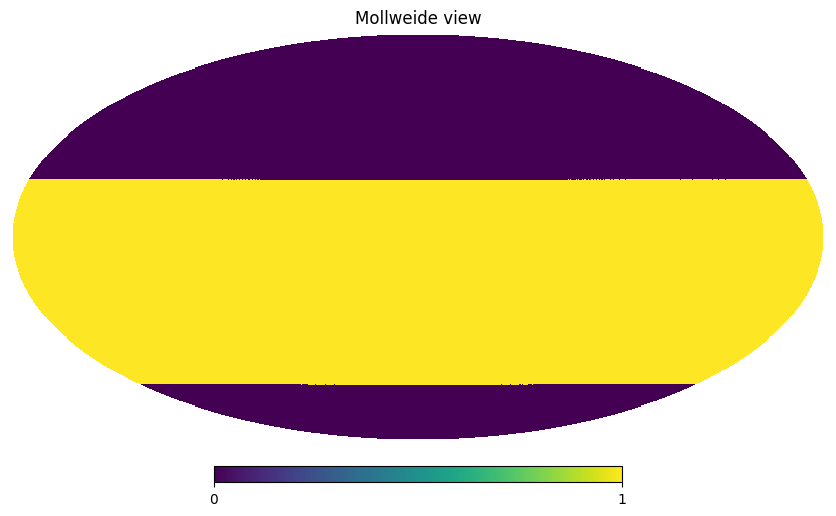

In [4]:
mask = np.zeros_like(h_n_spin_dict[2])
mask[h_n_spin_dict[2] != 0] = 1

hp.mollview(mask)

Then create the `FrameworkSystematics` object

In [5]:
nside = hp.npix2nside(h_n_spin_dict[2].size)

syste_object = FrameworkSystematics(nside=nside, nstokes=2, lmax=2*nside, list_spin_output=[-2,2])

Prepare the input sky maps

In [6]:
%%time
spin_sky_maps = syste_object.get_spin_sky_maps()

spin_sky_maps = {spin:spin_sky_maps[spin]*mask for spin in spin_sky_maps.keys()}

Calculating spectra from CAMB !
CPU times: user 27min 40s, sys: 12.3 s, total: 27min 52s
Wall time: 29 s


Plotting the real and imaginary part of the spin $2$, $-2$ maps

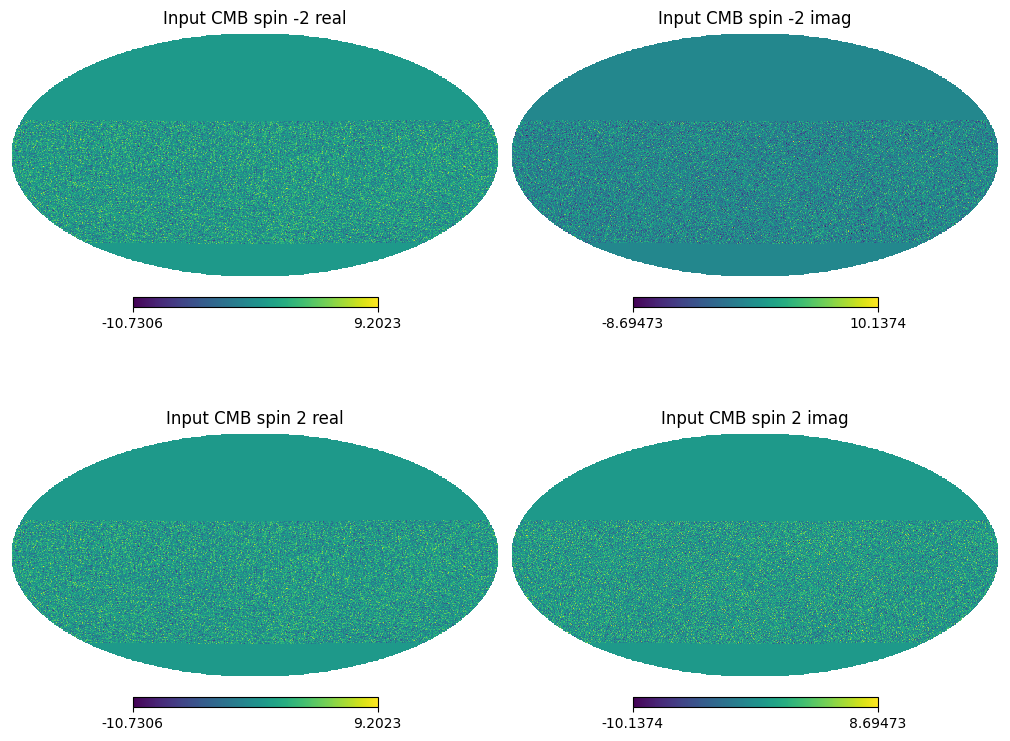

In [7]:
plt.figure(figsize=(10,8))
hp.mollview(spin_sky_maps[-2].real, sub=(2,2,1), title='Input CMB spin -2 real') #, min=-5, max=5
hp.mollview(spin_sky_maps[-2].imag, sub=(2,2,2), title='Input CMB spin -2 imag')
hp.mollview(spin_sky_maps[2].real, sub=(2,2,3), title='Input CMB spin 2 real')
hp.mollview(spin_sky_maps[2].imag, sub=(2,2,4), title='Input CMB spin 2 imag')

Checking the $Q$ and $U$ Stokes parameters of those spin maps

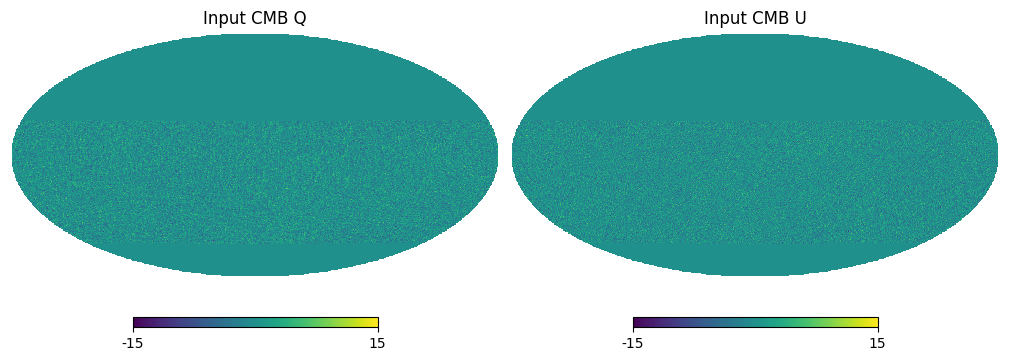

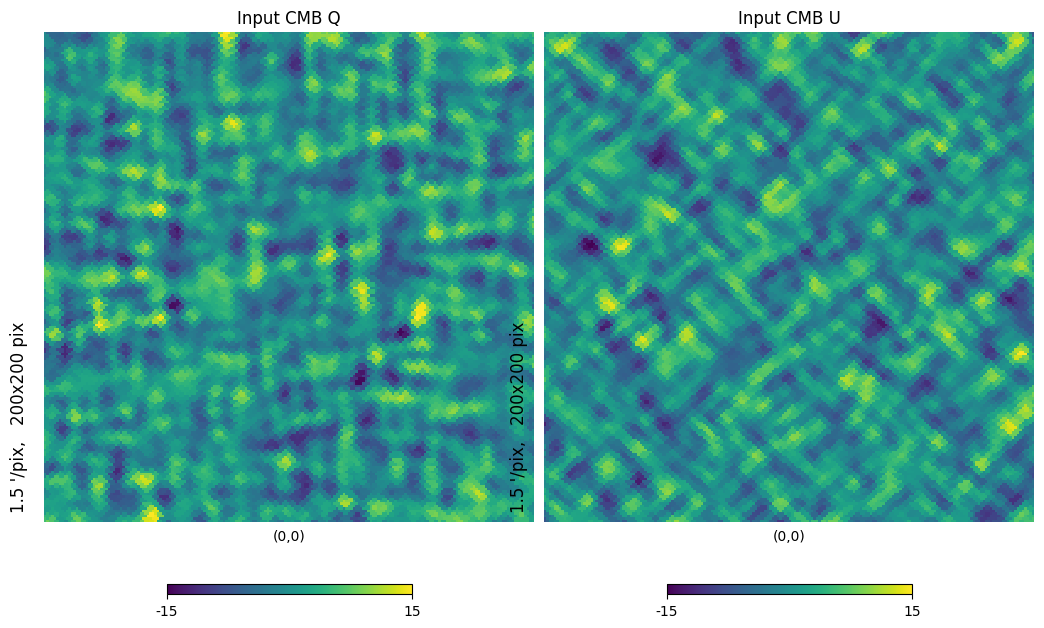

In [8]:
value = 15
plt.figure(figsize=(10,8))
hp.mollview((spin_sky_maps[2].real + spin_sky_maps[-2].real)/2, sub=(1,2,1), title='Input CMB Q', min=-value, max=value)
hp.mollview((spin_sky_maps[2].imag - spin_sky_maps[-2].imag)/2, sub=(1,2,2), title='Input CMB U', min=-value, max=value)

plt.figure(figsize=(10,8))
hp.gnomview(spin_sky_maps[2].real + spin_sky_maps[-2].real, sub=(1,2,1), title='Input CMB Q', min=-value, max=value)
hp.gnomview(spin_sky_maps[2].imag - spin_sky_maps[-2].imag, sub=(1,2,2), title='Input CMB U', min=-value, max=value)
plt.show()


For this basic mapmaking, we do not include systematics

In [9]:
spin_systematics_maps = {spin: 0 for spin in spin_sky_maps.keys()}

## Mapmaking

We can finally perform mapmaking

In [10]:
%%time
final_maps, inverse_mapmaking_matrix = syste_object.compute_total_maps(mask, h_n_spin_dict, spin_sky_maps, spin_systematics_maps, return_inverse_mapmaking_matrix=True)

Coupled spins for spin -2: [(4, -2), (0, 2)]
Coupled spins for spin 2: [(0, -2), (-4, 2)]
CPU times: user 18.3 s, sys: 3.55 s, total: 21.8 s
Wall time: 21.9 s


And form from the obtained maps the final $Q$ and $U$ maps

In [11]:
final_Q_map = (final_maps[-2,:] + final_maps[-1,:])/2.
final_U_map = 1j*(final_maps[-2,:] - final_maps[-1,:])/2.

We can plot them, both the real and imaginary parts for sanity tests

In [12]:
extended_final_maps = np.zeros((2,12*nside**2), dtype=complex)
extended_final_maps[0, mask != 0] = final_Q_map.real
extended_final_maps[1, mask != 0] = final_U_map.real

extended_final_maps_imag = np.zeros((2,12*nside**2), dtype=complex)
extended_final_maps_imag[0, mask != 0] = final_Q_map.imag
extended_final_maps_imag[1, mask != 0] = final_U_map.imag

/global/homes/m/mag/.conda/envs/beams_env/lib/python3.10/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


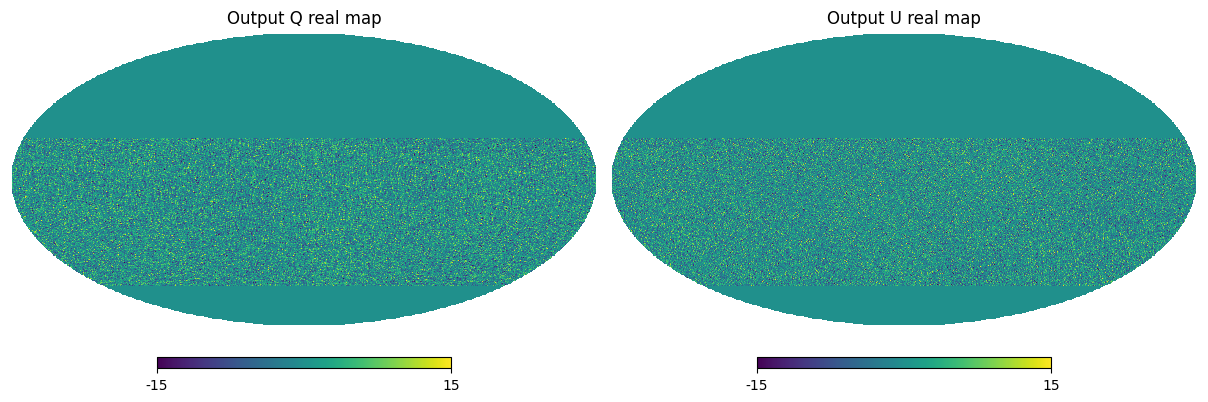

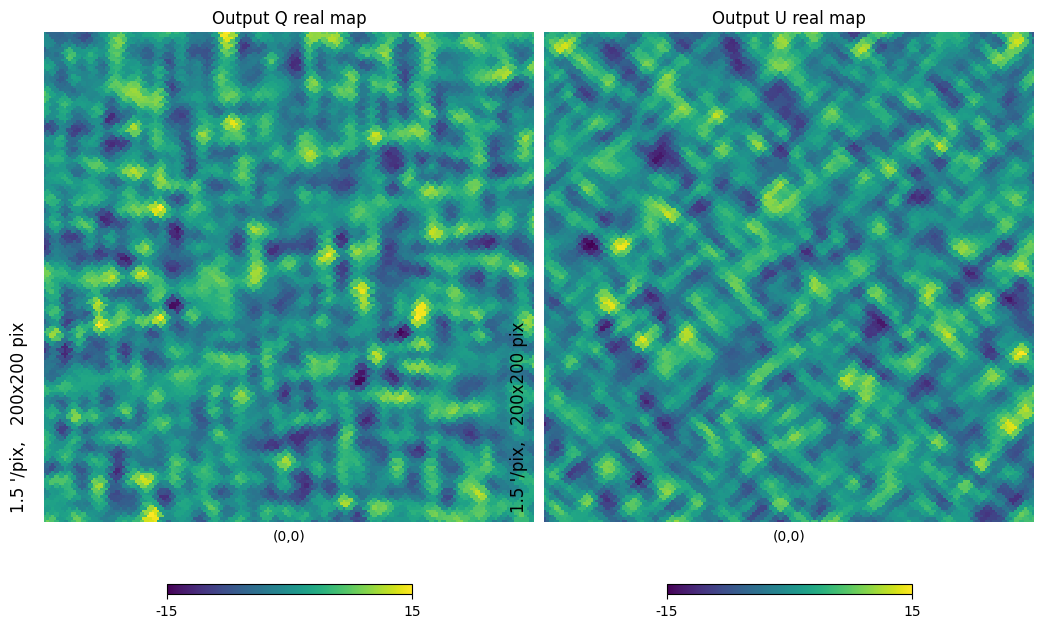

In [13]:
value = 15
plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps[0], sub=(1,2,1), title='Output Q real map', min=-value, max=value)
hp.mollview(extended_final_maps[1], sub=(1,2,2), title='Output U real map', min=-value, max=value)

plt.figure(figsize=(10,8))
hp.gnomview(extended_final_maps[0], sub=(1,2,1), title='Output Q real map', min=-value, max=value)
hp.gnomview(extended_final_maps[1], sub=(1,2,2), title='Output U real map', min=-value, max=value)


Note that the imaginary maps are supposed to be $0$

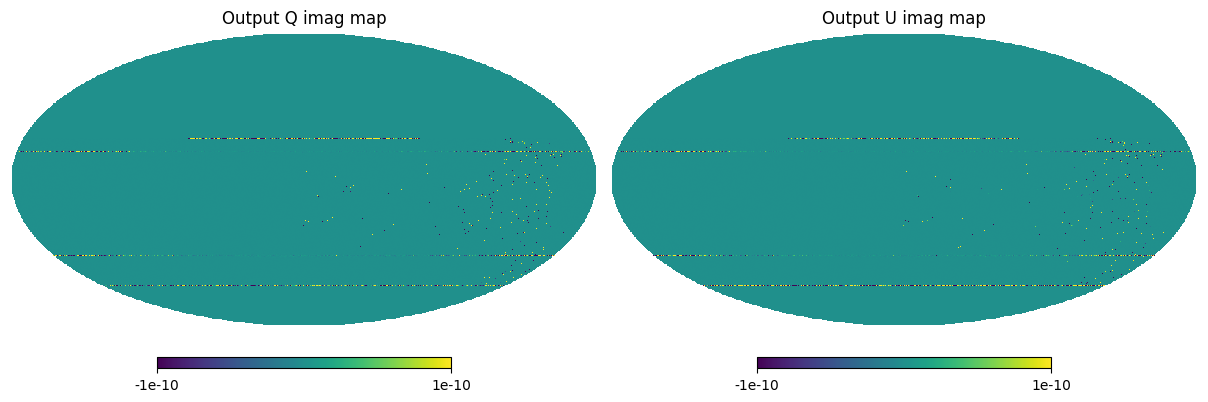

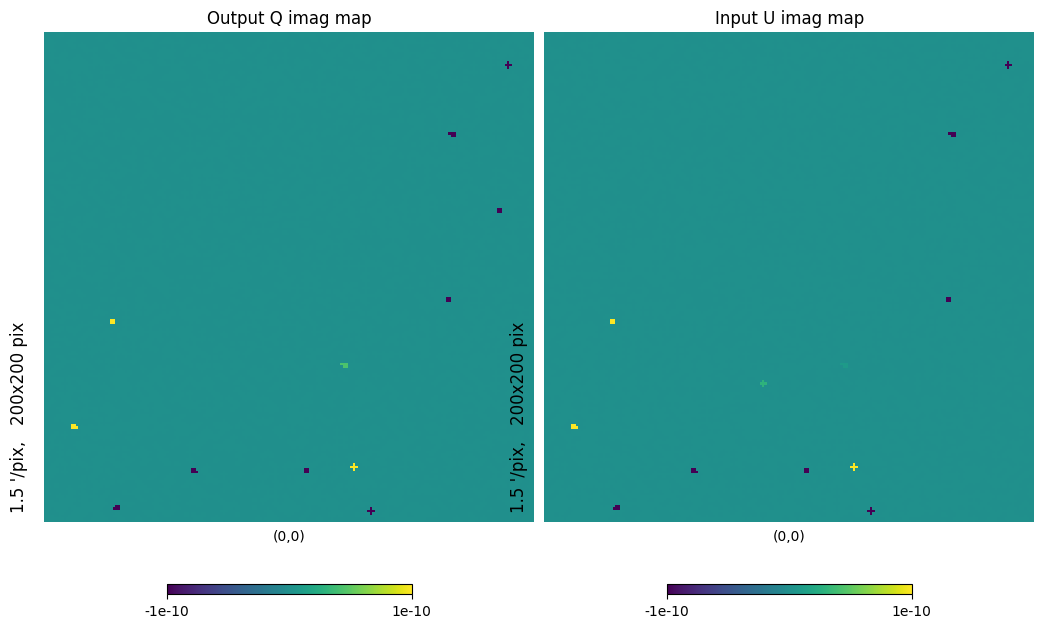

In [14]:
value = 1e-10
plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps_imag[0], sub=(1,2,1), title='Output Q imag map', min=-value, max=value)
hp.mollview(extended_final_maps_imag[1], sub=(1,2,2), title='Output U imag map', min=-value, max=value)
plt.show()


plt.figure(figsize=(10,8))
hp.gnomview(extended_final_maps_imag[0], sub=(1,2,1), title='Output Q imag map', min=-value, max=value)
hp.gnomview(extended_final_maps_imag[1], sub=(1,2,2), title='Input U imag map', min=-value, max=value)
plt.show()


This simply denotes bad condition number for the mapmaking matrix, please check the `advanced_mapmaking_1det.ipynb` notebook for more details about this. A mask based on this or the nhits should be enough to regularize the output maps. 